In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tqdm import tqdm
import random
import shutil
from IPython.display import Audio
from librosa.display import specshow
from librosa.display import waveshow
import uuid
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/AICOSS/Tasmanian_Birdsong/"
PATH = os.path.join(BASE_PATH, "preprocessed.csv")
AUDIO = os.path.join(BASE_PATH, "Input_audio")

df = pd.read_csv(PATH)
df.head()

,sample,species,call_type,start,end,aug_method
0,BD060A_CH01_20240328_220014_16kHz_290_320.wav,Masked Owl,screech,9.00,12.36,original
1,BD060A_CH01_20240331_210000_16kHz_660_690.wav,Masked Owl,screech,19.96,23.96,original
2,BD060A_CH01_20240331_210000_16kHz_1020_1050.wav,Masked Owl,screech,16.06,18.13,original
3,CH07_20240703_180000_16kHz_1380_1410.wav,Masked Owl,screech,23.12,25.19,original
4,CH07_20240703_180000_16kHz_1810_1840.wav,Masked Owl,screech,18.65,20.72,original


In [6]:
def extract_all_features(input_dir):
    feature_list = []

    for file in tqdm(sorted(os.listdir(input_dir)), desc="전체 특징 추출 중"):
        try:
            file_path = os.path.join(input_dir, file)
            y, sr = librosa.load(file_path, sr=None)

            features = {'sample': file}

            zcr = librosa.feature.zero_crossing_rate(y).flatten()
            rms = librosa.feature.rms(y=y).flatten()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).flatten()
            bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).flatten()

            features['zcr_mean'] = np.mean(zcr)
            features['zcr_std'] = np.std(zcr)
            features['rms_mean'] = np.mean(rms)
            features['rms_std'] = np.std(rms)
            features['centroid_mean'] = np.mean(centroid)
            features['centroid_std'] = np.std(centroid)
            features['rolloff_mean'] = np.mean(rolloff)
            features['rolloff_std'] = np.std(rolloff)
            features['bandwidth_mean'] = np.mean(bandwidth)
            features['bandwidth_std'] = np.std(bandwidth)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
            for i in range(20):
                features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i])
                features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            for i in range(12):
                features[f'chroma_{i+1}_mean'] = np.mean(chroma[i])
                features[f'chroma_{i+1}_std'] = np.std(chroma[i])

            feature_list.append(features)

        except Exception as e:
            print(f"[!] {file} 처리 중 오류: {e}")

    return pd.DataFrame(feature_list)

In [7]:
features_df = extract_all_features(AUDIO)
features_df.to_csv(os.path.join(BASE_PATH, "audio_features_full.csv"), index=False)
features_df.head()

전체 특징 추출 중:  66%|██████▌   | 1316/2000 [02:39<00:33, 20.61it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
전체 특징 추출 중: 100%|██████████| 2000/2000 [03:12<00:00, 10.38it/s]


,sample,zcr_mean,zcr_std,rms_mean,rms_std,centroid_mean,centroid_std,rolloff_mean,rolloff_std,bandwidth_mean,...,chroma_8_mean,chroma_8_std,chroma_9_mean,chroma_9_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_12_mean,chroma_12_std
0,BD060A_CH01_20240328_220014_16kHz_290_320.wav,0.211633,0.077423,0.077280,0.095525,2242.702452,510.153839,4329.672759,1309.274354,1821.314296,...,0.431625,0.341059,0.461831,0.257414,0.514799,0.291456,0.520908,0.254151,0.570150,0.328782
1,BD060A_CH01_20240328_220014_16kHz_290_320_pitc...,0.233997,0.093046,0.051721,0.062038,2391.127311,523.739216,4597.214033,1347.075402,1801.679950,...,0.267230,0.220487,0.338727,0.242587,0.407989,0.336083,0.463828,0.255903,0.532127,0.311737
2,BD060A_CH01_20240331_210000_16kHz_1020_1050.wav,0.377434,0.051184,0.082788,0.023532,3487.427819,327.654064,6251.201923,282.536556,2231.503633,...,0.541196,0.289154,0.506308,0.292377,0.503819,0.276046,0.521077,0.205002,0.733892,0.276116
3,BD060A_CH01_20240331_210000_16kHz_660_690.wav,0.242133,0.182935,0.066327,0.087920,2420.391088,1551.519636,3389.570933,2047.867143,1411.045919,...,0.415824,0.316202,0.451835,0.304426,0.536810,0.345986,0.497229,0.306671,0.451457,0.282508
4,BD060A_CH01_20240331_210000_16kHz_660_690_stre...,0.239510,0.188546,0.040243,0.056489,2395.650754,1555.557093,3609.933036,2023.409294,1396.801684,...,0.381462,0.328601,0.342956,0.280425,0.447011,0.353195,0.445044,0.338443,0.437088,0.325377


/tmp/ipython-input-26-3315493907.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature', y='importance', data=perm_df, palette='pastel')


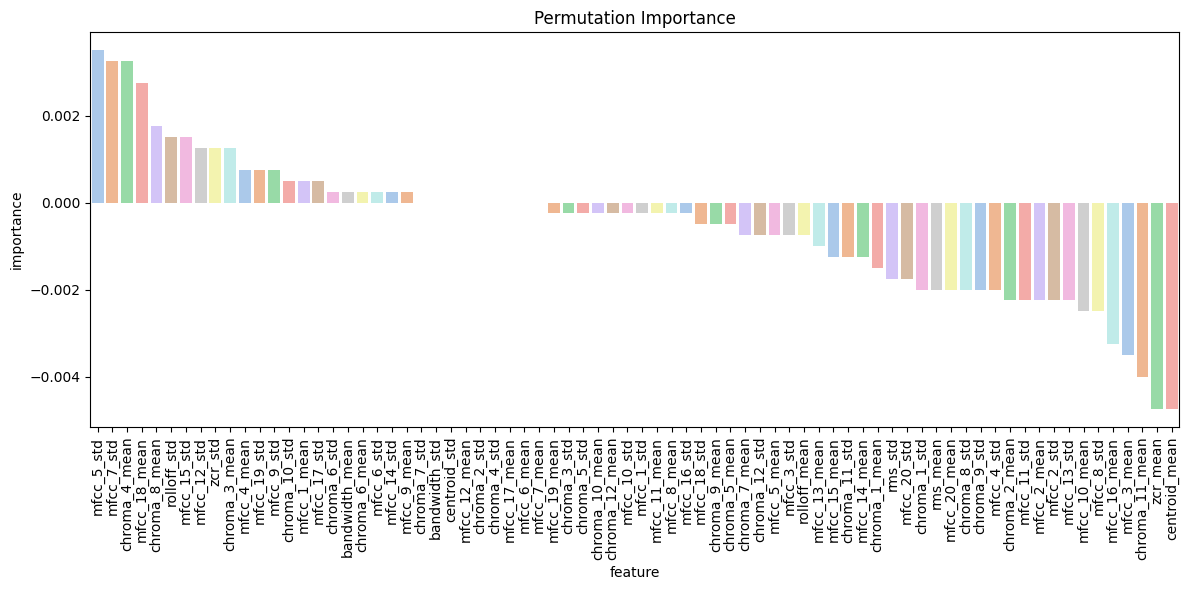

In [26]:
df_merged = features_df.merge(df[['sample', 'call_type']], on='sample')

X = df_merged.drop(columns=['sample', 'call_type'])
y = LabelEncoder().fit_transform(df_merged['call_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm.importances_mean
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='importance', data=perm_df, palette='pastel')
plt.xticks(rotation=90)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

In [30]:
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

100%|===================| 3985/4000 [01:04<00:00]       

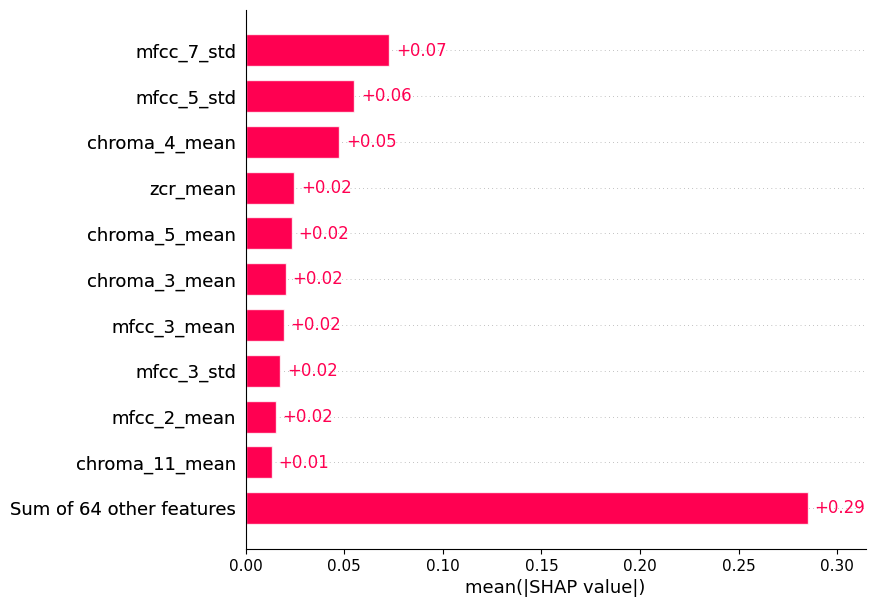

In [32]:
shap_values_class0 = shap_values[:, :, 0]
shap.plots.bar(shap_values_class0, max_display=11)

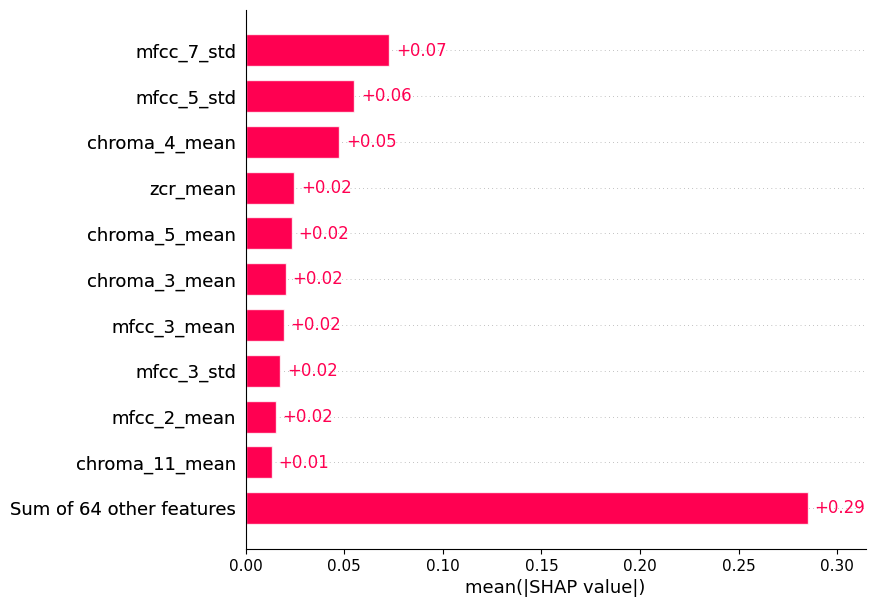

In [33]:
shap_values_class1 = shap_values[:, :, 1]
shap.plots.bar(shap_values_class1, max_display=11)

In [35]:
mean_importance = np.abs(shap_values_class0.values).mean(axis=0)

feature_names = X.columns.tolist()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importance
})

top_df = importance_df.sort_values(by='importance', ascending=False).head(10).reset_index(drop=True)

top_df.head(10)

,feature,importance
0,mfcc_7_std,0.072925
1,mfcc_5_std,0.055047
2,chroma_4_mean,0.047503
3,zcr_mean,0.024687
4,chroma_5_mean,0.023551
5,chroma_3_mean,0.020229
6,mfcc_3_mean,0.019401
7,mfcc_3_std,0.017682
8,mfcc_2_mean,0.015418
9,chroma_11_mean,0.013301


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

selected_features = top_df['feature'].tolist()
f_df = df_merged[selected_features].copy()
f_df['label'] = df_merged['call_type']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(f_df.drop(columns=['label']))
y = f_df['label'].values

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_encoded, test_size=0.10, stratify=y_encoded, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

In [42]:
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [43]:
print("데이터 분할 완료:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"라벨 분포 (train): {np.bincount(y_train)}")
print(f"라벨 분포 (val): {np.bincount(y_val)}")
print(f"라벨 분포 (test): {np.bincount(y_test)}")

데이터 분할 완료:
Train: (1440, 10), Val: (360, 10), Test: (200, 10)
라벨 분포 (train): [680 760]
라벨 분포 (val): [170 190]
라벨 분포 (test): [ 94 106]


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

latent_dim = 20
label_dim = len(le.classes_)
feature_dim = top_df.shape[0]

class FeatureExtractor(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.D = D
    def forward(self, x, y):
        return self.D.get_intermediate_features(x, y)

class Generator(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z, labels):
        labels = F.one_hot(labels, num_classes=label_dim).float()
        x = torch.cat([z, labels], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.label_dim = label_dim
        self.embed = nn.Embedding(label_dim, label_dim)
        self.fc1 = nn.Linear(input_dim + label_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.aux_class = nn.Linear(64, label_dim)

    def forward(self, x, y):
        y_embed = self.embed(y)
        x = torch.cat([x, y_embed], dim=1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        out_adv = torch.sigmoid(self.fc3(h2))
        out_cls = self.aux_class(h2)
        return out_adv, out_cls

    def get_intermediate_features(self, x, y):
        y_embed = self.embed(y)
        x = torch.cat([x, y_embed], dim=1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return h2

In [64]:
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

adv_loss_fn = nn.BCELoss()
cls_loss_fn = nn.CrossEntropyLoss()

G = Generator(latent_dim, label_dim, feature_dim)
D = Discriminator(feature_dim, label_dim)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 100
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G.to(device)
D.to(device)

g_loss_history = []
d_loss_history = []

for epoch in range(epochs):
    G.train()
    D.train()
    d_losses, g_losses = [], []

    for real_data, real_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_data, real_labels = real_data.to(device), real_labels.to(device)
        bs = real_data.size(0)

        real_targets = torch.full((bs, 1), 0.9, device=device)
        fake_targets = torch.zeros((bs, 1), device=device)

        z = torch.randn(bs, latent_dim, device=device)
        fake_data = G(z, real_labels)

        real_out_adv, real_out_cls = D(real_data, real_labels)
        fake_out_adv, fake_out_cls = D(fake_data.detach(), real_labels)

        d_adv_loss = adv_loss_fn(real_out_adv, real_targets) + adv_loss_fn(fake_out_adv, fake_targets)
        d_cls_loss = cls_loss_fn(real_out_cls, real_labels)
        d_loss = d_adv_loss + d_cls_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        z = torch.randn(bs, latent_dim, device=device)
        gen_data = G(z, real_labels)
        out_adv, out_cls = D(gen_data, real_labels)

        real_feat = D.get_intermediate_features(real_data, real_labels).detach()
        fake_feat = D.get_intermediate_features(gen_data, real_labels)
        fm_loss = F.l1_loss(fake_feat, real_feat)

        g_adv_loss = adv_loss_fn(out_adv, real_targets)
        g_cls_loss = cls_loss_fn(out_cls, real_labels)
        g_loss = g_adv_loss + g_cls_loss + fm_loss

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

        g_loss_history.append(np.mean(g_losses))
        d_loss_history.append(np.mean(d_losses))

    print(f"[{epoch+1}/{epochs}] D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 125.00it/s]


[1/100] D Loss: 2.0089 | G Loss: 1.4209


Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 152.30it/s]


[2/100] D Loss: 1.9290 | G Loss: 1.2975


Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 145.29it/s]


[3/100] D Loss: 1.7848 | G Loss: 1.1883


Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 137.90it/s]


[4/100] D Loss: 1.6216 | G Loss: 1.0647


Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 140.39it/s]


[5/100] D Loss: 1.5112 | G Loss: 0.9527


Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 146.94it/s]


[6/100] D Loss: 1.4505 | G Loss: 0.8952


Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 136.66it/s]


[7/100] D Loss: 1.4139 | G Loss: 0.8628


Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 146.49it/s]


[8/100] D Loss: 1.3965 | G Loss: 0.8487


Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 149.75it/s]


[9/100] D Loss: 1.3895 | G Loss: 0.8371


Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 130.86it/s]


[10/100] D Loss: 1.3866 | G Loss: 0.8314


Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 144.11it/s]


[11/100] D Loss: 1.3832 | G Loss: 0.8282


Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 136.61it/s]


[12/100] D Loss: 1.3819 | G Loss: 0.8236


Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 128.37it/s]


[13/100] D Loss: 1.3796 | G Loss: 0.8249


Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 135.63it/s]


[14/100] D Loss: 1.3777 | G Loss: 0.8214


Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 121.69it/s]


[15/100] D Loss: 1.3764 | G Loss: 0.8291


Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 94.96it/s]


[16/100] D Loss: 1.3750 | G Loss: 0.8204


Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 98.69it/s]


[17/100] D Loss: 1.3756 | G Loss: 0.8325


Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 91.17it/s]


[18/100] D Loss: 1.3767 | G Loss: 0.8225


Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 49.73it/s]


[19/100] D Loss: 1.3767 | G Loss: 0.8309


Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 47.53it/s]


[20/100] D Loss: 1.3768 | G Loss: 0.8217


Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 51.02it/s]


[21/100] D Loss: 1.3742 | G Loss: 0.8254


Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 55.17it/s]


[22/100] D Loss: 1.3739 | G Loss: 0.8255


Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 80.64it/s]


[23/100] D Loss: 1.3757 | G Loss: 0.8221


Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 79.33it/s]


[24/100] D Loss: 1.3728 | G Loss: 0.8260


Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 114.99it/s]


[25/100] D Loss: 1.3754 | G Loss: 0.8189


Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 78.09it/s]


[26/100] D Loss: 1.3755 | G Loss: 0.8257


Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 83.30it/s]


[27/100] D Loss: 1.3738 | G Loss: 0.8222


Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 79.20it/s]


[28/100] D Loss: 1.3741 | G Loss: 0.8262


Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 93.85it/s]


[29/100] D Loss: 1.3719 | G Loss: 0.8260


Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 97.55it/s]


[30/100] D Loss: 1.3712 | G Loss: 0.8284


Epoch 31/100: 100%|██████████| 45/45 [00:01<00:00, 40.25it/s]


[31/100] D Loss: 1.3703 | G Loss: 0.8281


Epoch 32/100: 100%|██████████| 45/45 [00:01<00:00, 29.67it/s]


[32/100] D Loss: 1.3698 | G Loss: 0.8272


Epoch 33/100: 100%|██████████| 45/45 [00:01<00:00, 28.71it/s]


[33/100] D Loss: 1.3719 | G Loss: 0.8300


Epoch 34/100: 100%|██████████| 45/45 [00:01<00:00, 38.73it/s]


[34/100] D Loss: 1.3726 | G Loss: 0.8339


Epoch 35/100: 100%|██████████| 45/45 [00:01<00:00, 28.85it/s]


[35/100] D Loss: 1.3714 | G Loss: 0.8315


Epoch 36/100: 100%|██████████| 45/45 [00:01<00:00, 25.00it/s]


[36/100] D Loss: 1.3709 | G Loss: 0.8298


Epoch 37/100: 100%|██████████| 45/45 [00:01<00:00, 39.09it/s]


[37/100] D Loss: 1.3696 | G Loss: 0.8325


Epoch 38/100: 100%|██████████| 45/45 [00:01<00:00, 41.48it/s]


[38/100] D Loss: 1.3718 | G Loss: 0.8318


Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 55.42it/s]


[39/100] D Loss: 1.3708 | G Loss: 0.8369


Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 77.02it/s]


[40/100] D Loss: 1.3722 | G Loss: 0.8331


Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 127.82it/s]


[41/100] D Loss: 1.3744 | G Loss: 0.8358


Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 130.88it/s]


[42/100] D Loss: 1.3708 | G Loss: 0.8292


Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 132.16it/s]


[43/100] D Loss: 1.3745 | G Loss: 0.8338


Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 126.08it/s]


[44/100] D Loss: 1.3729 | G Loss: 0.8388


Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 124.04it/s]


[45/100] D Loss: 1.3723 | G Loss: 0.8312


Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 134.25it/s]


[46/100] D Loss: 1.3727 | G Loss: 0.8363


Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 121.16it/s]


[47/100] D Loss: 1.3742 | G Loss: 0.8384


Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 134.07it/s]


[48/100] D Loss: 1.3726 | G Loss: 0.8353


Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 129.45it/s]


[49/100] D Loss: 1.3717 | G Loss: 0.8350


Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 137.18it/s]


[50/100] D Loss: 1.3726 | G Loss: 0.8381


Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 137.78it/s]


[51/100] D Loss: 1.3724 | G Loss: 0.8390


Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 135.68it/s]


[52/100] D Loss: 1.3736 | G Loss: 0.8406


Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 126.05it/s]


[53/100] D Loss: 1.3714 | G Loss: 0.8356


Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 135.77it/s]


[54/100] D Loss: 1.3693 | G Loss: 0.8350


Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 130.41it/s]


[55/100] D Loss: 1.3713 | G Loss: 0.8383


Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 119.65it/s]


[56/100] D Loss: 1.3725 | G Loss: 0.8413


Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 125.79it/s]


[57/100] D Loss: 1.3732 | G Loss: 0.8374


Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 127.90it/s]


[58/100] D Loss: 1.3708 | G Loss: 0.8378


Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 121.18it/s]


[59/100] D Loss: 1.3730 | G Loss: 0.8362


Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 138.21it/s]


[60/100] D Loss: 1.3730 | G Loss: 0.8399


Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 131.05it/s]


[61/100] D Loss: 1.3710 | G Loss: 0.8420


Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 129.61it/s]


[62/100] D Loss: 1.3734 | G Loss: 0.8411


Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 130.56it/s]


[63/100] D Loss: 1.3727 | G Loss: 0.8398


Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 133.77it/s]


[64/100] D Loss: 1.3706 | G Loss: 0.8392


Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 129.31it/s]


[65/100] D Loss: 1.3732 | G Loss: 0.8408


Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 109.77it/s]


[66/100] D Loss: 1.3738 | G Loss: 0.8387


Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 89.29it/s]


[67/100] D Loss: 1.3709 | G Loss: 0.8412


Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 94.87it/s]


[68/100] D Loss: 1.3715 | G Loss: 0.8395


Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 96.53it/s]


[69/100] D Loss: 1.3693 | G Loss: 0.8385


Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 95.89it/s]


[70/100] D Loss: 1.3715 | G Loss: 0.8437


Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 95.56it/s]


[71/100] D Loss: 1.3719 | G Loss: 0.8409


Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 97.89it/s]


[72/100] D Loss: 1.3729 | G Loss: 0.8420


Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 89.75it/s]


[73/100] D Loss: 1.3729 | G Loss: 0.8408


Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 84.10it/s]


[74/100] D Loss: 1.3708 | G Loss: 0.8430


Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 89.33it/s]


[75/100] D Loss: 1.3722 | G Loss: 0.8410


Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 145.23it/s]


[76/100] D Loss: 1.3713 | G Loss: 0.8458


Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 135.66it/s]


[77/100] D Loss: 1.3704 | G Loss: 0.8427


Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 146.86it/s]


[78/100] D Loss: 1.3715 | G Loss: 0.8424


Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 144.08it/s]


[79/100] D Loss: 1.3709 | G Loss: 0.8469


Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 130.26it/s]


[80/100] D Loss: 1.3706 | G Loss: 0.8438


Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 144.19it/s]


[81/100] D Loss: 1.3717 | G Loss: 0.8446


Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 147.39it/s]


[82/100] D Loss: 1.3720 | G Loss: 0.8481


Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 127.48it/s]


[83/100] D Loss: 1.3708 | G Loss: 0.8474


Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 133.42it/s]


[84/100] D Loss: 1.3714 | G Loss: 0.8473


Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 145.61it/s]


[85/100] D Loss: 1.3701 | G Loss: 0.8477


Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 127.34it/s]


[86/100] D Loss: 1.3717 | G Loss: 0.8498


Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 139.57it/s]


[87/100] D Loss: 1.3705 | G Loss: 0.8492


Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 144.43it/s]


[88/100] D Loss: 1.3707 | G Loss: 0.8467


Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 134.59it/s]


[89/100] D Loss: 1.3725 | G Loss: 0.8511


Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 126.36it/s]


[90/100] D Loss: 1.3723 | G Loss: 0.8499


Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 142.47it/s]


[91/100] D Loss: 1.3713 | G Loss: 0.8519


Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 128.38it/s]


[92/100] D Loss: 1.3710 | G Loss: 0.8468


Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 132.06it/s]


[93/100] D Loss: 1.3721 | G Loss: 0.8538


Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 137.92it/s]


[94/100] D Loss: 1.3710 | G Loss: 0.8489


Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 129.14it/s]


[95/100] D Loss: 1.3720 | G Loss: 0.8534


Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 134.61it/s]


[96/100] D Loss: 1.3698 | G Loss: 0.8511


Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 141.85it/s]


[97/100] D Loss: 1.3694 | G Loss: 0.8513


Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 123.92it/s]


[98/100] D Loss: 1.3713 | G Loss: 0.8547


Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 136.64it/s]


[99/100] D Loss: 1.3711 | G Loss: 0.8501


Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 132.74it/s]

[100/100] D Loss: 1.3706 | G Loss: 0.8553


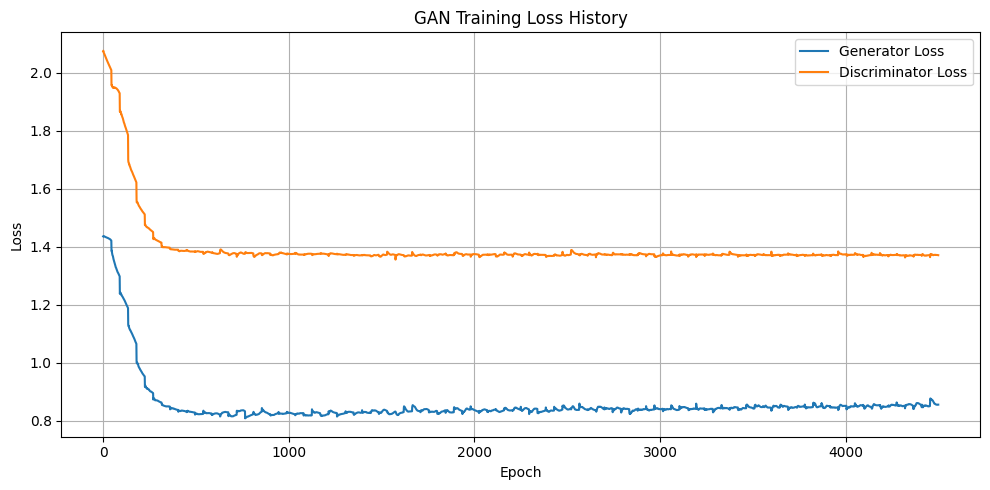

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(g_loss_history, label='Generator Loss')
plt.plot(d_loss_history, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

G.eval()

n_samples = len(X_test_tensor)
z = torch.randn(n_samples, latent_dim).to(device)
test_labels = y_test_tensor.to(device)
gen_samples = G(z, test_labels).detach().cpu().numpy()
true_labels = test_labels.cpu().numpy()

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred_real = clf.predict(X_test)
print("Real Test Set Result:")
print(classification_report(y_test, y_pred_real, target_names=le.classes_))

y_pred_gen = clf.predict(gen_samples)
print("GAN Generated Sample Result:")
print(classification_report(true_labels, y_pred_gen, target_names=le.classes_))

Real Test Set Result:
              precision    recall  f1-score   support

  chattering       0.85      0.87      0.86        94
     screech       0.88      0.86      0.87       106

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200

GAN Generated Sample Result:
              precision    recall  f1-score   support

  chattering       0.83      0.91      0.87        94
     screech       0.92      0.84      0.88       106

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.88       200



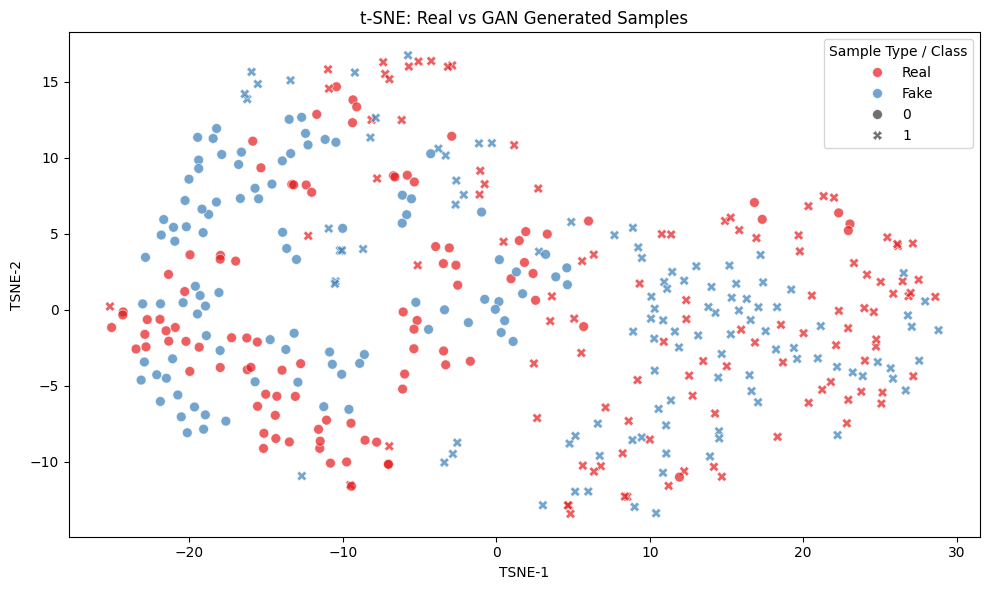

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_real_vis = X_test
y_real_vis = y_test

with torch.no_grad():
    G.eval()
    z = torch.randn(len(X_test), latent_dim, device=device)
    labels = torch.tensor(y_test, dtype=torch.long, device=device)
    X_fake_vis = G(z, labels).cpu().numpy()
    y_fake_vis = y_test

X_combined = np.vstack([X_real_vis, X_fake_vis])
y_combined = np.hstack([['Real'] * len(X_real_vis), ['Fake'] * len(X_fake_vis)])
label_combined = np.hstack([y_real_vis, y_fake_vis])

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_combined)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=y_combined,
    style=label_combined,
    palette='Set1',
    alpha=0.7,
    s=50
)
plt.title("t-SNE: Real vs GAN Generated Samples")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title='Sample Type / Class')
plt.tight_layout()
plt.show()